In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
seed_value = 42

def set_random_seed(seed_value):
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)

set_random_seed(seed_value)

In [4]:
BATCH_SIZE = 8
LR = 0.0001
EPOCH_NUM = 15
DROPOUT = 0.3

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_data, transform):
        self.img_data = [img for img in img_data if img[0].mode == 'RGB']
        self.transform = transform
    
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, idx):
        img, label = self.img_data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


img_data_paths = [r'../input/jellyfish-types/Train_Test_Valid/Train',
                  r'../input/jellyfish-types/Train_Test_Valid/valid']

data_name = ['train', 'valid']

img_data = {name: datasets.ImageFolder(path) for (name, path) in zip(data_name, img_data_paths)}
img_datasets = {name: ImageDataset(img_data[name], transform=transform) for name in img_data.keys()}
img_dataloaders = {name: DataLoader(img_datasets[name], batch_size=BATCH_SIZE, shuffle=True) for name in img_datasets.keys()}

In [6]:
def visualize_data(img_data):
    labels_map = {
        0: 'Moon Jellyfish',
        1: 'Barrel Jellyfish',
        2: 'Blue Jellyfish',
        3: 'Compass Jellyfish',
        4: 'Lions Mane Jellyfish',
        5: 'Mauve Stinger Jellyfish'
    }
    
    figure = plt.figure(figsize=(12, 12))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(img_data), size=(1,)).item()
        img, label = img_data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img)
    plt.show()

# visualize_data(img_data['train'])

In [7]:
model = models.resnet50(weights='DEFAULT')

# Update autograd parameters status
for param in model.parameters():
    param.required_grad = False

num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(DROPOUT),
    nn.Linear(num_features, 6)
)

# model.fc = nn.Linear(num_features, 6)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Set loss function
criterion = nn.CrossEntropyLoss()

# Set optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Set scheduler with weight decay every x epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [9]:
# Restart the model parameters
# os.remove('/kaggle/working/best_model_params.pt')

In [10]:
def train_model(model, criterion, optimizer, num_epochs):  
    # Set path to best model performance
    best_model_params_path = "/kaggle/working/best_model_params.pt"
    
    torch.save(model.state_dict(), best_model_params_path)
    
    best_acc = 0.0
    
    # Store loss and acc of each epoch
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Set train mode
        model.train()
        
        # Set up a progress bar for epochs
        epoch_progress = tqdm(enumerate(img_dataloaders['train']), 
                              total=len(img_dataloaders['train']), 
                              desc=f'Epoch {epoch + 1}/{num_epochs}')
        
        running_train_loss = 0.0
        running_train_acc = 0
        
        # Iterate over data.
        for batch_idx, (inputs, targets) in epoch_progress:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)            

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

            # Backward, parameters optimization
            loss.backward()
            optimizer.step()
            
            # Gather losses for statistics purposes
            running_train_loss += loss.item() * inputs.size(0)
            running_train_acc += torch.sum(preds == targets.data)
            
        scheduler.step()

        # Calculate training loss and accuracy
        t_loss = running_train_loss / len(img_dataloaders['train'].dataset)
        t_acc = running_train_acc.double() / len(img_dataloaders['train'].dataset)
        
        train_losses.append(t_loss)
        train_acc.append(t_acc)
                                
        # Evaluation mode
        model.eval()
        running_val_loss = 0.0
        running_val_acc = 0
        
        with torch.no_grad():
            for inputs, targets in img_dataloaders['valid']:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_loss = criterion(outputs, targets)
                
                running_val_acc += torch.sum(preds == targets.data)
                running_val_loss += val_loss.item() * inputs.size(0)
            
            v_loss = running_val_loss / len(img_dataloaders['valid'].dataset)
            v_acc = running_val_acc.double() / len(img_dataloaders['valid'].dataset)
            
            val_losses.append(v_loss)
            val_acc.append(v_acc)
            
            if v_acc > best_acc:
                best_acc = v_acc
                torch.save(model.state_dict(), best_model_params_path)
                
        tqdm.write(f'Epoch {epoch+1}/{num_epochs} - '
                   f'Train Loss: {t_loss:.4f} - '
                   f'Train Accuracy: {t_acc:.2%} - '
                   f'Validation Loss: {v_loss:.4f} - '
                   f'Validation Accuracy: {v_acc:.2%}')
        
    model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, val_losses, train_acc, val_acc

In [11]:
best_model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, EPOCH_NUM)

Epoch 1/15: 100%|██████████| 113/113 [00:17<00:00,  6.29it/s]


Epoch 1/15 - Train Loss: 1.2174 - Train Accuracy: 60.44% - Validation Loss: 0.8845 - Validation Accuracy: 69.23%


Epoch 2/15: 100%|██████████| 113/113 [00:10<00:00, 10.34it/s]


Epoch 2/15 - Train Loss: 0.4746 - Train Accuracy: 84.67% - Validation Loss: 0.6555 - Validation Accuracy: 79.49%


Epoch 3/15: 100%|██████████| 113/113 [00:11<00:00, 10.24it/s]


Epoch 3/15 - Train Loss: 0.3060 - Train Accuracy: 91.00% - Validation Loss: 0.6815 - Validation Accuracy: 74.36%


Epoch 4/15: 100%|██████████| 113/113 [00:11<00:00, 10.11it/s]


Epoch 4/15 - Train Loss: 0.1714 - Train Accuracy: 94.89% - Validation Loss: 0.6445 - Validation Accuracy: 79.49%


Epoch 5/15: 100%|██████████| 113/113 [00:11<00:00,  9.91it/s]


Epoch 5/15 - Train Loss: 0.1642 - Train Accuracy: 95.00% - Validation Loss: 0.7622 - Validation Accuracy: 76.92%


Epoch 6/15: 100%|██████████| 113/113 [00:11<00:00,  9.80it/s]


Epoch 6/15 - Train Loss: 0.1109 - Train Accuracy: 97.11% - Validation Loss: 1.0850 - Validation Accuracy: 71.79%


Epoch 7/15: 100%|██████████| 113/113 [00:11<00:00,  9.62it/s]


Epoch 7/15 - Train Loss: 0.0805 - Train Accuracy: 97.56% - Validation Loss: 0.8105 - Validation Accuracy: 82.05%


Epoch 8/15: 100%|██████████| 113/113 [00:11<00:00,  9.55it/s]


Epoch 8/15 - Train Loss: 0.0994 - Train Accuracy: 97.11% - Validation Loss: 0.9823 - Validation Accuracy: 76.92%


Epoch 9/15: 100%|██████████| 113/113 [00:11<00:00,  9.65it/s]


Epoch 9/15 - Train Loss: 0.1042 - Train Accuracy: 97.44% - Validation Loss: 0.8309 - Validation Accuracy: 76.92%


Epoch 10/15: 100%|██████████| 113/113 [00:11<00:00,  9.73it/s]


Epoch 10/15 - Train Loss: 0.0588 - Train Accuracy: 98.33% - Validation Loss: 0.7098 - Validation Accuracy: 79.49%


Epoch 11/15: 100%|██████████| 113/113 [00:11<00:00,  9.83it/s]


Epoch 11/15 - Train Loss: 0.0424 - Train Accuracy: 98.89% - Validation Loss: 0.6549 - Validation Accuracy: 79.49%


Epoch 12/15: 100%|██████████| 113/113 [00:11<00:00,  9.81it/s]


Epoch 12/15 - Train Loss: 0.0309 - Train Accuracy: 99.11% - Validation Loss: 0.7241 - Validation Accuracy: 76.92%


Epoch 13/15: 100%|██████████| 113/113 [00:11<00:00,  9.79it/s]


Epoch 13/15 - Train Loss: 0.0283 - Train Accuracy: 99.44% - Validation Loss: 0.8359 - Validation Accuracy: 74.36%


Epoch 14/15: 100%|██████████| 113/113 [00:11<00:00,  9.73it/s]


Epoch 14/15 - Train Loss: 0.0211 - Train Accuracy: 99.44% - Validation Loss: 0.6476 - Validation Accuracy: 82.05%


Epoch 15/15: 100%|██████████| 113/113 [00:11<00:00,  9.66it/s]


Epoch 15/15 - Train Loss: 0.0227 - Train Accuracy: 99.56% - Validation Loss: 0.9388 - Validation Accuracy: 76.92%


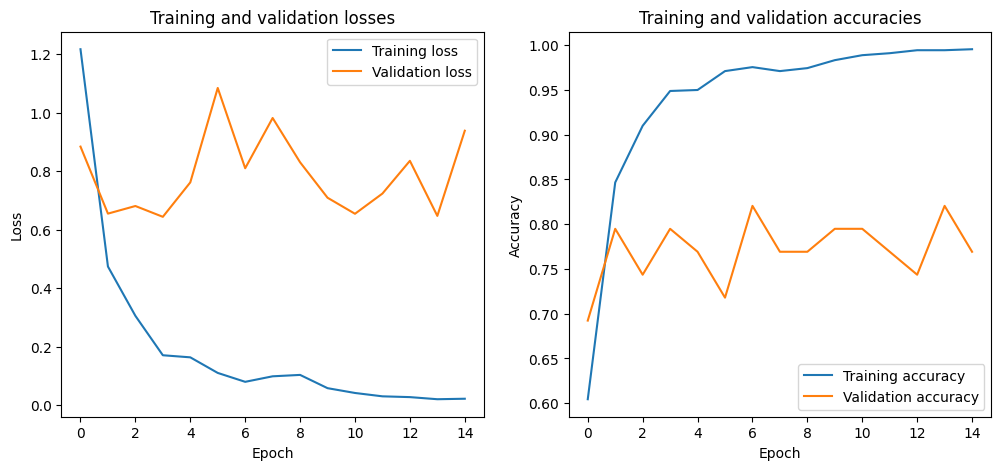

In [12]:
def visualize_loss_acc():
    # Move accuracies from CUDA tensor to CPU before plotting
    train_acc_cpu = [tensor.to('cpu') for tensor in train_acc]
    val_acc_cpu = [tensor.to('cpu') for tensor in val_acc]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    
    ax1.plot(train_loss, label='Training loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and validation losses')
    
    ax2.plot(train_acc_cpu, label='Training accuracy')
    ax2.plot(val_acc_cpu, label='Validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Training and validation accuracies')
    
    plt.show()

visualize_loss_acc()

In [13]:
# Prepare the test set for prediction
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_dataset = datasets.ImageFolder(r'../input/jellyfish-types/Train_Test_Valid/test', transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

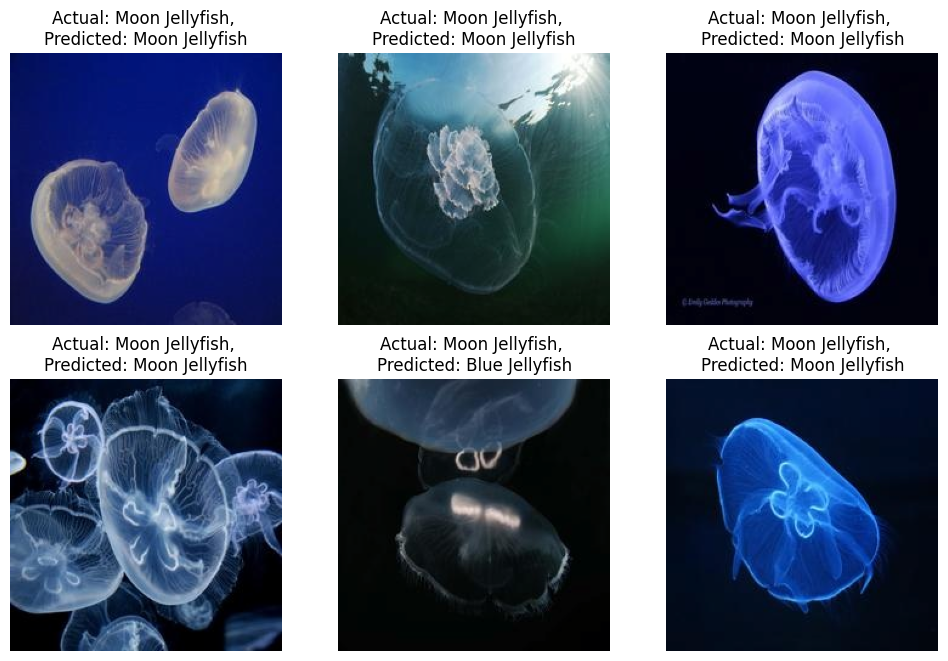

In [14]:
def inverse_transform(img_tensor):
    invTrans = transforms.Compose(
        [transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0])]
    )
    
    inversed_img = invTrans(img_tensor)
    return inversed_img


def visualize_data(model, num_images=6):
    labels_map = {
        0: 'Moon Jellyfish',
        1: 'Barrel Jellyfish',
        2: 'Blue Jellyfish',
        3: 'Compass Jellyfish',
        4: 'Lions Mane Jellyfish',
        5: 'Mauve Stinger Jellyfish'
    } 

    figure = plt.figure(figsize=(12, 12))
    cols, rows = 3, 3
    images_so_far = 0
    
    model.eval() # Set the model to evaluation mode
   
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            if images_so_far == num_images:
                break
                
            inputs = inputs.to(device)
            targets = targets.to(device)

            output = model(inputs)
            _, predicted_class = torch.max(output, 1)

            # Inverse transformation image
            inputs = inverse_transform(inputs)
            
            # Convert the input imag
            input_image = inputs.squeeze(0).permute(1, 2, 0).cpu().numpy()

            figure.add_subplot(rows, cols, images_so_far + 1)
            plt.title(f"Actual: {labels_map[targets.item()]}, \nPredicted: {labels_map[predicted_class.item()]}")
            plt.axis("off")
            plt.imshow(input_image)

            images_so_far += 1

    plt.show()

visualize_data(best_model)